In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
from dataclasses import dataclass

@dataclass
class ExperimentResult:
  key: str
  bytes_pr_operation: int
  operations: int

In [21]:
lines = []
with open('/content/drive/MyDrive/3peer.log') as f:
    lines = f.readlines()

In [26]:
machine_readable_lines = filter(lambda x: x.startswith('$'), lines)
stripped_lines = map(lambda x: x[1:].strip(), machine_readable_lines)
split_lines = map(lambda x: x.split(';'), stripped_lines)
experiment_results = list(map(lambda x: ExperimentResult(x[0], int(x[1]), int(x[2])), split_lines))

In [25]:
sorted_lines = sorted(split_lines, key=lambda x: x[0])
sorted_lines

[['DMA_READ', '1', '151149'],
 ['DMA_READ', '1024', '148241'],
 ['DMA_READ', '2048', '142591'],
 ['DMA_READ', '4096', '144508'],
 ['DMA_READ', '8192', '135948'],
 ['DMA_READ', '16384', '126594'],
 ['DMA_READ', '32768', '100344'],
 ['DMA_READ', '65536', '74781'],
 ['DMA_READ', '131072', '37822'],
 ['DMA_READ', '262144', '23066'],
 ['DMA_READ', '524288', '12463'],
 ['DMA_READ', '1048576', '7118'],
 ['DMA_READ', '2097152', '3486'],
 ['DMA_READ', '4194304', '1586'],
 ['DMA_READ', '8388608', '808'],
 ['DMA_READ_VECTOR_1', '1024', '147608'],
 ['DMA_READ_VECTOR_1', '2048', '134101'],
 ['DMA_READ_VECTOR_1', '4096', '132555'],
 ['DMA_READ_VECTOR_1', '8192', '131176'],
 ['DMA_READ_VECTOR_1', '16384', '120268'],
 ['DMA_READ_VECTOR_1', '32768', '94205'],
 ['DMA_READ_VECTOR_1', '65536', '56351'],
 ['DMA_READ_VECTOR_1', '131072', '37390'],
 ['DMA_READ_VECTOR_1', '262144', '22435'],
 ['DMA_READ_VECTOR_1', '524288', '12420'],
 ['DMA_READ_VECTOR_1', '1048576', '7262'],
 ['DMA_READ_VECTOR_1', '2097152',

In [186]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math

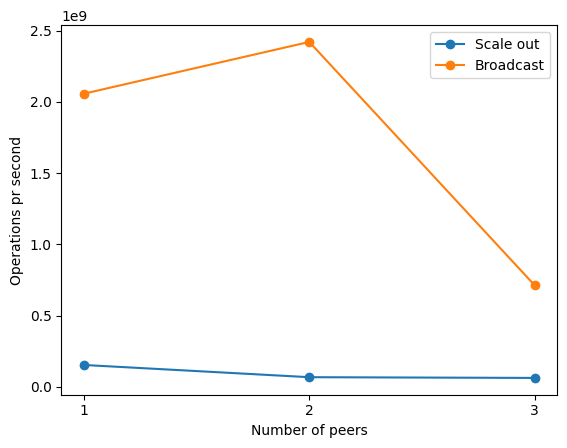

In [79]:
PEERS = 3

SCALE_OUT_KEY_PREFIX = 'PIO_WRITE_SCALE_OUT_'
BROADCAST_KEY_PREFIX = 'PIO_BROADCAST_'

SCALE_OUT_KEYS = [SCALE_OUT_KEY_PREFIX + str(i) for i in range(1, PEERS + 1)]
BROADCAST_KEYS = [BROADCAST_KEY_PREFIX + str(i) for i in range(1, PEERS + 1)]

scale_out_results = []
broadcast_results = []

for result in experiment_results:
  if result.key.startswith(SCALE_OUT_KEY_PREFIX):
    scale_out_results.append(result)
  elif result.key.startswith(BROADCAST_KEY_PREFIX):
    broadcast_results.append(result)

assert len(scale_out_results) == PEERS
assert len(broadcast_results) == PEERS

data = dict()
data['scale_out'] = list(map(lambda x: x.operations / 2, scale_out_results))
data['broadcast'] = list(map(lambda x: x.operations / 2, broadcast_results))

x_label = 'Number of peers'
y_label = 'Operations pr second'

plt.plot(range(1, PEERS + 1), data['scale_out'], label='Scale out', marker='o')
plt.plot(range(1, PEERS + 1), data['broadcast'], label='Broadcast', marker='o')
plt.xticks(range(1, PEERS + 1))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

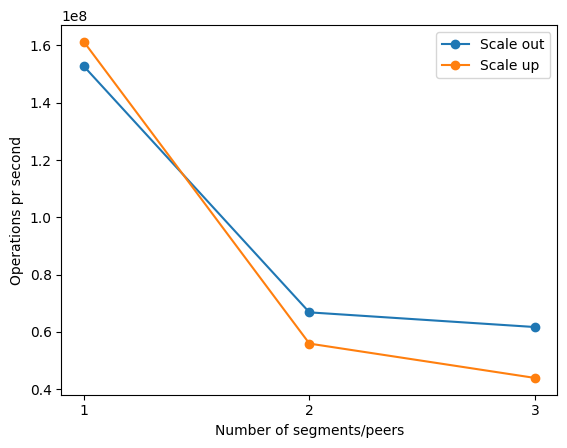

In [78]:
PEERS = 3

SCALE_OUT_KEY_PREFIX = 'PIO_WRITE_SCALE_OUT_'
SCALE_UP_KEY_PREFIX = 'PIO_WRITE_SCALE_UP'

SCALE_OUT_KEYS = [SCALE_OUT_KEY_PREFIX + str(i) for i in range(1, PEERS + 1)]
SCALE_UP_KEYS = [SCALE_UP_KEY_PREFIX + str(i) for i in range(1, PEERS + 1)]

scale_out_results = []
scale_up_results = []

for result in experiment_results:
  if result.key.startswith(SCALE_OUT_KEY_PREFIX):
    scale_out_results.append(result)
  elif result.key.startswith(SCALE_UP_KEY_PREFIX) and result.key.endswith(('1', '2', '3')):
    scale_up_results.append(result)

assert len(scale_out_results) == PEERS
assert len(scale_up_results) == PEERS

data = dict()
data['scale_out'] = list(map(lambda x: x.operations / 2, scale_out_results))
data['scale_up'] = list(map(lambda x: x.operations / 2, scale_up_results))

x_label = 'Number of segments/peers'
y_label = 'Operations pr second'

plt.plot(range(1, PEERS + 1), data['scale_out'], label='Scale out', marker='o')
plt.plot(range(1, PEERS + 1), data['scale_up'], label='Scale up', marker='o')
plt.xticks(range(1, PEERS + 1))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

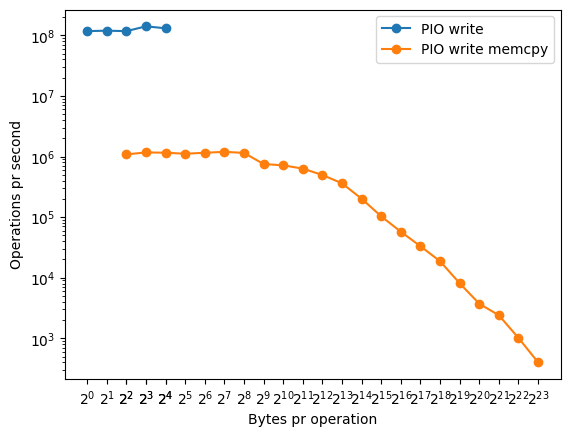

In [77]:
PEERS = 3

PIO_WRITE_KEY = 'PIO_WRITE'
PIO_WRITE_MEMCPY_KEY = 'PIO_WRITE_MEMCPY'

pio_write_results = []
pio_write_memcpy_results = []

for result in experiment_results:
  if result.key == (PIO_WRITE_KEY):
    existing_result = next((r for r in pio_write_results if r.bytes_pr_operation == result.bytes_pr_operation), None)
    if existing_result:
      existing_result.operations = result.operations
    else:
      pio_write_results.append(result)
  if result.key == (PIO_WRITE_MEMCPY_KEY):
    pio_write_memcpy_results.append(result)

data = dict()
data['pio_write'] = list(map(lambda x: x.operations / 2, pio_write_results))
data['pio_write_memcpy'] = list(map(lambda x: x.operations / 2, pio_write_memcpy_results))

pio_write_x_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_results))
pio_write_memcpy_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_memcpy_results))

x_label = 'Bytes pr operation'
y_label = 'Operations pr second'

plt.plot(pio_write_x_labels, data['pio_write'], label='PIO write', marker='o')
plt.plot(pio_write_memcpy_labels, data['pio_write_memcpy'], label='PIO write memcpy', marker='o')

plt.xscale('log', base=2)
plt.xticks(pio_write_x_labels + pio_write_memcpy_labels)
plt.yscale('log')

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

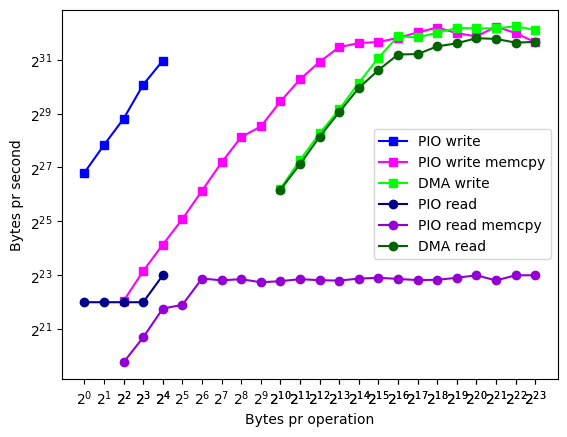

In [119]:
PEERS = 3

PIO_WRITE_KEY = 'PIO_WRITE'
PIO_READ_KEY = 'PIO_READ'
PIO_WRITE_MEMCPY_KEY = 'PIO_WRITE_MEMCPY'
PIO_READ_MEMCPY_KEY = 'PIO_READ_MEMCPY'
DMA_WRITE_KEY = 'DMA_WRITE'
DMA_READ_KEY = 'DMA_READ'
DMA_MIN = 1000

pio_write_results = []
pio_read_results = []
pio_write_memcpy_results = []
pio_read_memcpy_results = []
dma_write_results = []
dma_read_results = []

for result in experiment_results:
  if result.key == (PIO_WRITE_KEY):
    existing_result = next((r for r in pio_write_results if r.bytes_pr_operation == result.bytes_pr_operation), None)
    if existing_result:
      existing_result.operations = result.operations
    else:
      pio_write_results.append(result)
  if result.key == (PIO_WRITE_MEMCPY_KEY):
    pio_write_memcpy_results.append(result)
  if result.key == (DMA_WRITE_KEY) and result.bytes_pr_operation >= DMA_MIN:
    dma_write_results.append(result)

  if result.key == (PIO_READ_KEY):
    existing_result = next((r for r in pio_read_results if r.bytes_pr_operation == result.bytes_pr_operation), None)
    if existing_result:
      existing_result.operations = result.operations
    else:
      pio_read_results.append(result)
  if result.key == (PIO_READ_MEMCPY_KEY):
    pio_read_memcpy_results.append(result)
  if result.key == (DMA_READ_KEY) and result.bytes_pr_operation >= DMA_MIN:
    dma_read_results.append(result)


data = dict()
data['pio_write'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, pio_write_results))
data['pio_write_memcpy'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, pio_write_memcpy_results))
data['dma_write'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, dma_write_results))
data['pio_read'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, pio_read_results))
data['pio_read_memcpy'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, pio_read_memcpy_results))
data['dma_read'] = list(map(lambda x: (x.operations * x.bytes_pr_operation) / 2, dma_read_results))

pio_write_x_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_results))
pio_write_memcpy_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_memcpy_results))
dma_write_labels = list(map(lambda x: x.bytes_pr_operation, dma_write_results))
pio_read_x_labels = list(map(lambda x: x.bytes_pr_operation, pio_read_results))
pio_read_memcpy_labels = list(map(lambda x: x.bytes_pr_operation, pio_read_memcpy_results))
dma_read_labels = list(map(lambda x: x.bytes_pr_operation, dma_read_results))

x_label = 'Bytes pr operation'
y_label = 'Bytes pr second'

plt.plot(pio_write_x_labels, data['pio_write'], label='PIO write', marker='s', color='blue')
plt.plot(pio_write_memcpy_labels, data['pio_write_memcpy'], label='PIO write memcpy', marker='s', color='fuchsia')
plt.plot(dma_write_labels, data['dma_write'], label='DMA write', marker='s', color='lime')
plt.plot(pio_read_x_labels, data['pio_read'], label='PIO read', marker='o', color='darkblue')
plt.plot(pio_read_memcpy_labels, data['pio_read_memcpy'], label='PIO read memcpy', marker='o', color='darkviolet')
plt.plot(dma_read_labels, data['dma_read'], label='DMA read', marker='o', color='darkgreen')

plt.xscale('log', base=2)
plt.xticks(pio_write_x_labels + pio_write_memcpy_labels + dma_write_labels)
plt.yscale('log', base=2)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

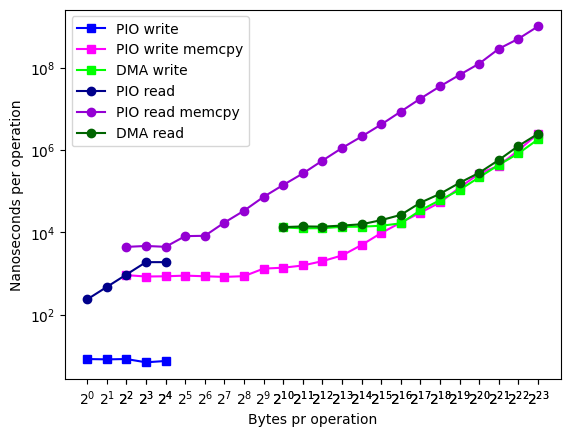

In [118]:
PEERS = 3

PIO_WRITE_KEY = 'PIO_WRITE'
PIO_READ_KEY = 'PIO_READ'
PIO_WRITE_MEMCPY_KEY = 'PIO_WRITE_MEMCPY'
PIO_READ_MEMCPY_KEY = 'PIO_READ_MEMCPY'
DMA_WRITE_KEY = 'DMA_WRITE'
DMA_READ_KEY = 'DMA_READ'
DMA_MIN = 1000

pio_write_results = []
pio_read_results = []
pio_write_memcpy_results = []
pio_read_memcpy_results = []
dma_write_results = []
dma_read_results = []

for result in experiment_results:
  if result.key == (PIO_WRITE_KEY):
    existing_result = next((r for r in pio_write_results if r.bytes_pr_operation == result.bytes_pr_operation), None)
    if existing_result:
      existing_result.operations = result.operations
    else:
      pio_write_results.append(result)
  if result.key == (PIO_WRITE_MEMCPY_KEY):
    pio_write_memcpy_results.append(result)
  if result.key == (DMA_WRITE_KEY) and result.bytes_pr_operation >= DMA_MIN:
    dma_write_results.append(result)

  if result.key == (PIO_READ_KEY):
    existing_result = next((r for r in pio_read_results if r.bytes_pr_operation == result.bytes_pr_operation), None)
    if existing_result:
      existing_result.operations = result.operations
    else:
      pio_read_results.append(result)
  if result.key == (PIO_READ_MEMCPY_KEY):
    pio_read_memcpy_results.append(result)
  if result.key == (DMA_READ_KEY) and result.bytes_pr_operation >= DMA_MIN:
    dma_read_results.append(result)

def operations_to_nanoseconds(operations: int):
  return (2 / operations) * 1000000000


data = dict()
data['pio_write'] = list(map(lambda x: operations_to_nanoseconds(x.operations), pio_write_results))
data['pio_write_memcpy'] = list(map(lambda x: operations_to_nanoseconds(x.operations), pio_write_memcpy_results))
data['dma_write'] = list(map(lambda x: operations_to_nanoseconds(x.operations), dma_write_results))
data['pio_read'] = list(map(lambda x: operations_to_nanoseconds(x.operations), pio_read_results))
data['pio_read_memcpy'] = list(map(lambda x: operations_to_nanoseconds(x.operations), pio_read_memcpy_results))
data['dma_read'] = list(map(lambda x: operations_to_nanoseconds(x.operations), dma_read_results))

pio_write_x_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_results))
pio_write_memcpy_labels = list(map(lambda x: x.bytes_pr_operation, pio_write_memcpy_results))
dma_write_labels = list(map(lambda x: x.bytes_pr_operation, dma_write_results))
pio_read_x_labels = list(map(lambda x: x.bytes_pr_operation, pio_read_results))
pio_read_memcpy_labels = list(map(lambda x: x.bytes_pr_operation, pio_read_memcpy_results))
dma_read_labels = list(map(lambda x: x.bytes_pr_operation, dma_read_results))

x_label = 'Bytes pr operation'
y_label = 'Nanoseconds per operation'

plt.plot(pio_write_x_labels, data['pio_write'], label='PIO write', marker='s', color='blue')
plt.plot(pio_write_memcpy_labels, data['pio_write_memcpy'], label='PIO write memcpy', marker='s', color='fuchsia')
plt.plot(dma_write_labels, data['dma_write'], label='DMA write', marker='s', color='lime')
plt.plot(pio_read_x_labels, data['pio_read'], label='PIO read', marker='o', color='darkblue')
plt.plot(pio_read_memcpy_labels, data['pio_read_memcpy'], label='PIO read memcpy', marker='o', color='darkviolet')
plt.plot(dma_read_labels, data['dma_read'], label='DMA read', marker='o', color='darkgreen')

plt.xscale('log', base=2)
plt.xticks(pio_write_x_labels + pio_write_memcpy_labels + dma_write_labels)
plt.yscale('log', base=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

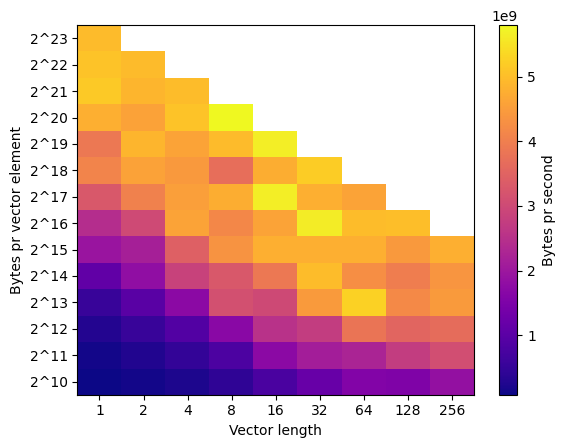

In [196]:
DMA_VECTOR_KEY_PREFIX = 'DMA_WRITE_VECTOR_'

dma_vector_results = [result for result in experiment_results if result.key.startswith(DMA_VECTOR_KEY_PREFIX)]

xs = []
ys = []
zs = []

for result in dma_vector_results:
  vec_len = int(result.key[len(DMA_VECTOR_KEY_PREFIX):])
  xs.append(vec_len)
  ys.append(result.bytes_pr_operation)
  zs.append((result.operations / 2) * result.bytes_pr_operation * vec_len)

x_label = 'Vector length'
y_label = 'Bytes pr vector element'
z_label = 'Bytes pr second'


data = pd.DataFrame({'vec_len': xs, 'bytes_pr_vec_el': ys, 'bytes_pr_sec': zs})
pivot_data = data.pivot(columns='vec_len', index='bytes_pr_vec_el', values='bytes_pr_sec')
heatmap = plt.imshow(pivot_data, cmap='plasma', aspect='auto', interpolation='none', origin='lower')
plt.colorbar(heatmap, label=z_label)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xticks(range(len(pivot_data.columns)), pivot_data.columns)
plt.yticks(range(len(pivot_data.index)), map(lambda x: f"2^{math.log2(x):.0f}", pivot_data.index))
plt.show()